### Known cell type identification
- use Allen Brain Institute SMART-seq data from the mouse isocortex and HPF (Yao et al. 2021 Cell) as the reference
- TODO: subselect cell types based on brain regions

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from dredFISH.Utils.__init__plots import *
from dredFISH.Analysis import TissueGraph
from dredFISH.Analysis import Classification

import importlib
importlib.reload(TissueGraph)
importlib.reload(Classification)

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

In [1]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t2'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 60M
lrwxrwxrwx 1 fangming wollmanlab   67 Jul  8 11:14 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv -> ../Dataset1-t1/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
lrwxrwxrwx 1 fangming wollmanlab   69 Jul  8 11:14 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv -> ../Dataset1-t1/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
drwxr-xr-x 2 fangming wollmanlab 4.0K Jul  8 11:15 .
-rw-r--r-- 1 fangming wollmanlab  132 Jul  8 11:41 TMG.json
-rw-r--r-- 1 fangming wollmanlab  53M Jul  8 11:41 cell.h5ad
-rw-r--r-- 1 fangming wollmanlab 6.8M Jul  8 11:41 isozone.h5ad
-rw-r--r-- 1 fangming wollmanlab    3 Jul  8 11:41 Taxonomy_Allen_types.csv
drwxrwxrwx 7 zach     wollmanlab 4.0K Jul  8 12:44 ..
{"layers_graph": [[0, 1]], "layer_taxonomy_mapping": {"0": 0, "1": 0}, "Taxonomies": ["Allen_types"], "Layers": ["cell", "isozone"]}

In [3]:
%%time
# TMG object from scratch
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=True, # create an empty one
                                  ) 
# add cell layer
TMG.create_cell_layer(metric='cosine') # metric is for feature graph
logging.info(f"TMG has {len(TMG.Layers)} Layers")

INFO:root:In TMG.create_cell_layer
INFO:root:Started reading matrices and metadata
INFO:root:done reading files
INFO:root:77846 cells, minimum counts = 1872.0
INFO:root:building spatial graphs
INFO:root:Building spatial graphs for 1 sections


/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t2/cell.h5ad


INFO:root:updating anndata
INFO:root:done building spatial graph
INFO:root:building feature graphs
INFO:root:building feature graph using cosine
INFO:root:done with create_cell_layer
INFO:root:TMG has 1 Layers


CPU times: user 1min 34s, sys: 1min 4s, total: 2min 38s
Wall time: 38.3 s


In [4]:
%%time
# create known cell type classifier and train and predict
allen_classifier = Classification.KnownCellTypeClassifier(
    TMG.Layers[0], 
    tax_name='Allen_types',
    ref='allen_smrt_dpnmf',
    ref_levels=['class_label', 'neighborhood_label', 'subclass_label'], #, 'cluster_label'], 
    model='knn',
)
allen_classifier.train(verbose=True)
type_mat = allen_classifier.classify()

type_mat.shape, type_mat

INFO:root:Loading and preprocessing data
INFO:root:77846 cells, minimum counts = 1872.0
INFO:root:iteration 1/3
INFO:root:Current round: level_0
INFO:root:iteration 2/3
INFO:root:Current round: level_1_cluster_GABAergic
INFO:root:Current round: level_1_cluster_Glutamatergic
INFO:root:Current round: level_1_cluster_Non-Neuronal
INFO:root:iteration 3/3
INFO:root:Current round: level_2_cluster_CGE
INFO:root:Current round: level_2_cluster_MGE
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_DG/SUB/CA
INFO:root:Current round: level_2_cluster_L2/3 IT
INFO:root:Current round: level_2_cluster_L4/5/6 IT Car3
INFO:root:Current round: level_2_cluster_NP/CT/L6b
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_PT
INFO:root:Current round: level_2_cluster_Other


CPU times: user 11.7 s, sys: 555 ms, total: 12.3 s
Wall time: 12.2 s


((77846, 3),
 array([['GABAergic', 'MGE', 'Sst Chodl'],
        ['GABAergic', 'MGE', 'Sst Chodl'],
        ['GABAergic', 'MGE', 'Pvalb'],
        ...,
        ['Glutamatergic', 'NP/CT/L6b', 'L5/6 NP CTX'],
        ['GABAergic', 'CGE', 'Lamp5'],
        ['Glutamatergic', 'PT', 'L4 RSP-ACA']], dtype=object))

In [5]:
%%time
# register results in TMG and create Isozones
TMG.add_type_information(0, 
                         type_mat[:,-1], # only record the finest level of cell types
                         allen_classifier.tax) # not exactly sure what .tax does
TMG.create_isozone_layer()
logging.info(f"TMG has {len(TMG.Layers)} Layers")

INFO:root:TMG has 2 Layers


/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t2/isozone.h5ad
CPU times: user 399 ms, sys: 15.3 ms, total: 415 ms
Wall time: 409 ms


### Save to files
TMG is saved as a config json file, one AnnData file per layer, and one dataframe per taxonomy. 

In [6]:
%%time
TMG.save()

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Type' as categorical
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Type' as categorical
INFO:root:saved


CPU times: user 379 ms, sys: 135 ms, total: 514 ms
Wall time: 666 ms


## check results

In [7]:
!head $basepth"/TMG.json"

{"layers_graph": [[0, 1]], "layer_taxonomy_mapping": {"0": 0, "1": 0}, "Taxonomies": ["Allen_types"], "Layers": ["cell", "isozone"]}

In [8]:
xy = TMG.Layers[0].XY
x, y = xy[:,0], xy[:,1]
c = TMG.Layers[0].Type
df = pd.DataFrame(np.vstack([x,y,c]).T, columns=['x', 'y', 'c'])

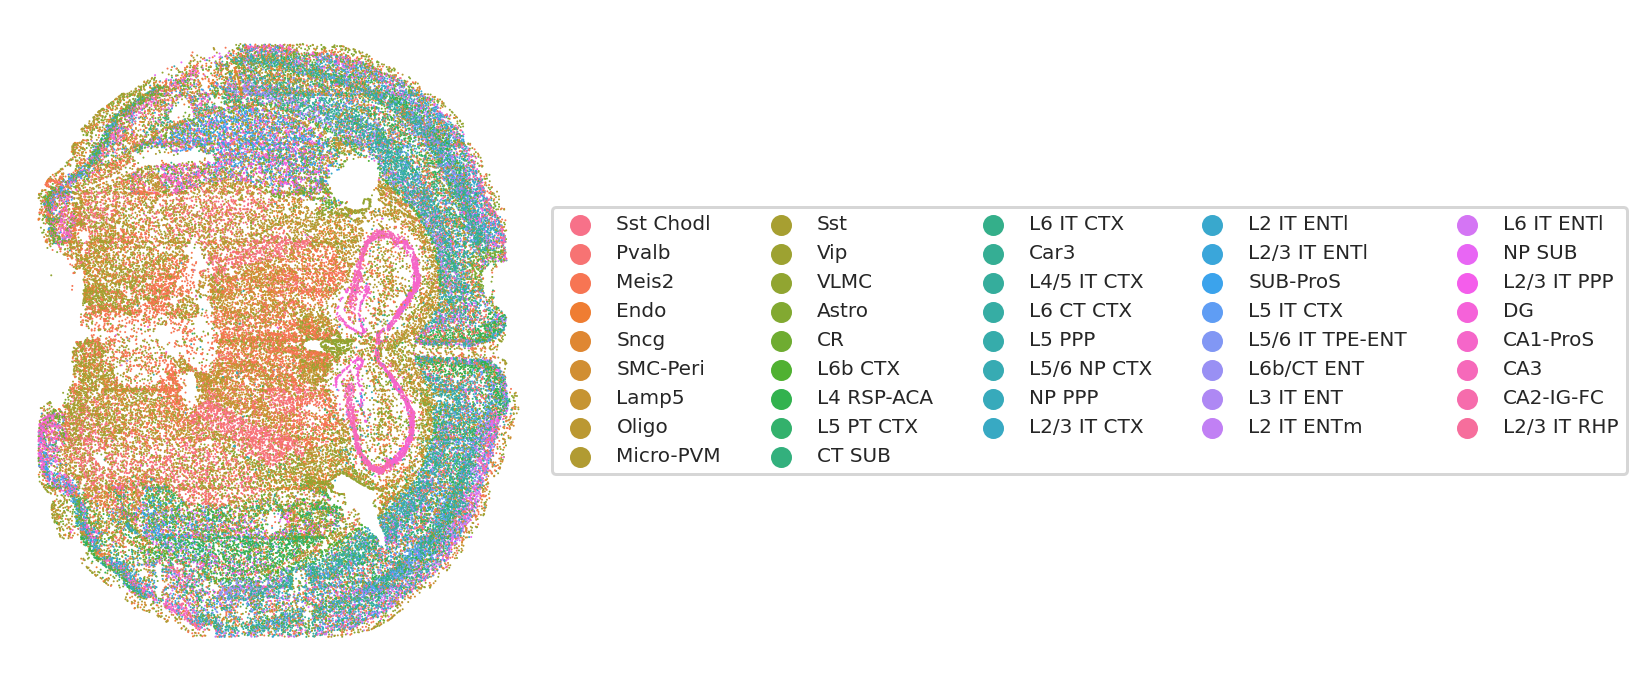

In [9]:
kwargs = dict(s=1, edgecolor='none')

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='x', y='y', hue='c', ax=ax, **kwargs)
ax.set_aspect('equal')
ax.axis('off')
ax.legend(ncol=5, bbox_to_anchor=(1,0.5), loc='center left', fontsize=10)
plt.show()